In [40]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() 
from matplotlib import pyplot

# Data Splitting 
import os.path
import argparse
import random
import datetime as dt
import copy

# Data Augmentation 
import PIL
#
import cv2
import glob
import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image # to read images
import os

### Use Keras Model Architecture 

In [41]:
#For Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras import regularizers, optimizers
from keras.optimizers import SGD
import tensorflow as tf

### Dataset Preparation 

In [42]:
dataset_path = './data'
anns_file_path = dataset_path + '/' + 'annotations.json'

In [43]:
# Read Annotations
with open(anns_file_path , 'r') as f:
    dataset = json.loads(f.read())

In [44]:
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

print(nr_images) # Total Number of images

1500


In [45]:
# category Dataframe and  Select 'six new Category(ouput classes)' for category Dataframe
cat_df = pd.DataFrame(categories)
keyValList = ['Cigarette','Paper cup','Unlabeled litter','Clear plastic bottle','Drink can']
category_df = pd.DataFrame([d for d in categories if d['name'] in keyValList])

# Annotation Dataframe
ann_df = pd.DataFrame(anns)
# Images Dataframe
image_df = pd.DataFrame(imgs)

In [46]:
# Dropping unncessary columns for Keras fundamental CNN model
category_df = category_df.drop(['supercategory'], axis = 1)
image_df = image_df.drop(['license','flickr_url','coco_url','date_captured','flickr_640_url'], axis=1)
ann_df = ann_df.drop(['id'], axis=1)

In [47]:
merged_img_ann_df = pd.merge(left=image_df, right=ann_df, left_on='id', right_on='image_id')
final_merged_df = pd.merge(left=merged_img_ann_df, right=category_df, left_on='category_id', right_on='id') 
final_merged_df = final_merged_df.drop(['id_x','id_y','category_id','image_id','width','height'], axis = 1 )
final_merged_df = final_merged_df.rename(columns={"file_name": "filename", "name": "category"})
final_merged_df.head()

,filename,segmentation,area,bbox,iscrowd,category
0,batch_1/000010.jpg,"[[670.0, 993.0, 679.0, 998.0, 684.0, 1001.0, 6...",73832.5,"[632.0, 987.0, 500.0, 374.0]",0,Clear plastic bottle
1,batch_1/000019.jpg,"[[354.0, 1268.0, 351.0, 1252.0, 347.0, 1237.0,...",98379.5,"[209.0, 920.0, 454.0, 562.0]",0,Clear plastic bottle
2,batch_1/000019.jpg,"[[1239.0, 841.0, 1247.0, 842.0, 1252.0, 835.0,...",43678.0,"[1212.0, 822.0, 179.0, 446.0]",0,Clear plastic bottle
3,batch_1/000001.jpg,"[[1062.0, 752.0, 1123.0, 744.0, 1153.0, 744.0,...",68667.0,"[826.0, 744.0, 464.0, 205.0]",0,Clear plastic bottle
4,batch_1/000005.jpg,"[[825.0, 731.0, 824.0, 670.0, 825.0, 649.0, 82...",17734.0,"[824.0, 557.0, 89.0, 236.0]",0,Clear plastic bottle


In [48]:
# New Dataframe with selective columns
df = final_merged_df[['filename','bbox','category']]

In [49]:
# storing bounding box values as seperate columns
df = pd.concat([df , df['bbox'].apply(pd.Series)], axis = 1)
df.columns = ['filename','bbox','category', 'x_min','y_min','x_max', 'y_max'] # x_max : width and y_max : height
df = df.drop(['bbox',], axis=1)

In [50]:
df.head()

,filename,category,x_min,y_min,x_max,y_max
0,batch_1/000010.jpg,Clear plastic bottle,632.0,987.0,500.0,374.0
1,batch_1/000019.jpg,Clear plastic bottle,209.0,920.0,454.0,562.0
2,batch_1/000019.jpg,Clear plastic bottle,1212.0,822.0,179.0,446.0
3,batch_1/000001.jpg,Clear plastic bottle,826.0,744.0,464.0,205.0
4,batch_1/000005.jpg,Clear plastic bottle,824.0,557.0,89.0,236.0


In [51]:
# Calculate maximum x and maximum y points
df['x_max'] = df['x_max']+df['x_min']
df['y_max'] = df['y_max']+df['y_min']
# Convert float columns to integer
for col in  df.columns[2:]:
    df[col] = df[col].astype(int)
    

In [52]:
df.tail()

,filename,category,x_min,y_min,x_max,y_max
1760,batch_9/000090.jpg,Unlabeled litter,1482,1710,1579,1769
1761,batch_9/000095.jpg,Unlabeled litter,435,1439,514,1493
1762,batch_9/000095.jpg,Unlabeled litter,401,1846,576,1939
1763,batch_9/000095.jpg,Unlabeled litter,614,3712,707,3871
1764,batch_9/000095.jpg,Unlabeled litter,1042,1165,1167,1237


### Fetch, crop and store image data

In [53]:
# Reading all the images from multiple folders and added to the list
folders = glob.glob(dataset_path +'//*')
imagenames_list = []
for folder in folders:
    for f in glob.glob(folder+'/*'):   
        imagenames_list.append(f)

In [54]:
train_data = []  
for ind in df.index:
    bbox = (df['x_min'][ind],df['y_min'][ind],df['x_max'][ind],df['y_max'][ind])
    img=Image.open(os.path.join(dataset_path,df['filename'][ind]))
    img=img.crop(bbox)
    img = img.resize((128, 128), Image.ANTIALIAS)
    img = image.img_to_array(img)
    train_data.append(img)

X = np.array(train_data)

In [55]:
df = df.drop(['x_min','x_max','y_min','y_max'], axis=1)

In [56]:
df.head()

,filename,category
0,batch_1/000010.jpg,Clear plastic bottle
1,batch_1/000019.jpg,Clear plastic bottle
2,batch_1/000019.jpg,Clear plastic bottle
3,batch_1/000001.jpg,Clear plastic bottle
4,batch_1/000005.jpg,Clear plastic bottle


In [57]:
df1 = pd.get_dummies(df, columns=["category"])
df1.head()

,filename,category_Cigarette,category_Clear plastic bottle,category_Drink can,category_Paper cup,category_Unlabeled litter
0,batch_1/000010.jpg,0,1,0,0,0
1,batch_1/000019.jpg,0,1,0,0,0
2,batch_1/000019.jpg,0,1,0,0,0
3,batch_1/000001.jpg,0,1,0,0,0
4,batch_1/000005.jpg,0,1,0,0,0


In [58]:
# 
y = np.array(df1.drop(['filename'],axis=1))
print(y.shape)
print(X.shape)

(1765, 5)
(1765, 128, 128, 3)


### Data Split 

In [59]:
# Data split Randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

### Build Keras Model 

In [60]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(5, 5), activation="relu", input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [61]:
#Model Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 124, 124, 16)      1216      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 58, 58, 32)        12832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 25, 25, 64)       

In [62]:
#Optimizer used in the models
opt = SGD(lr=0.01, momentum=0.9)

## Keras Model Implementation Using 'Accuracy' Method

In [71]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [72]:
# Model fit
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=30)

Train on 1412 samples, validate on 353 samples
Epoch 1/200
1412/1412 [==============================] - 33s 24ms/step - loss: 1.2383 - accuracy: 0.5475 - val_loss: 1.2526 - val_accuracy: 0.5042
Epoch 2/200
1412/1412 [==============================] - 33s 23ms/step - loss: 0.9405 - accuracy: 0.6530 - val_loss: 1.1939 - val_accuracy: 0.5581
Epoch 3/200
1412/1412 [==============================] - 47s 34ms/step - loss: 0.7880 - accuracy: 0.7096 - val_loss: 1.2928 - val_accuracy: 0.5892
Epoch 4/200
1412/1412 [==============================] - 53s 37ms/step - loss: 0.6231 - accuracy: 0.7769 - val_loss: 1.2357 - val_accuracy: 0.5411
Epoch 5/200
1412/1412 [==============================] - 44s 31ms/step - loss: 0.6365 - accuracy: 0.7755 - val_loss: 1.3355 - val_accuracy: 0.5496
Epoch 6/200
1412/1412 [==============================] - 52s 37ms/step - loss: 0.5604 - accuracy: 0.8081 - val_loss: 1.5859 - val_accuracy: 0.5751
Epoch 7/200
1412/1412 [==============================] - 47s 33ms/step 

1412/1412 [==============================] - 44s 31ms/step - loss: 0.1932 - accuracy: 0.9412 - val_loss: 1.7813 - val_accuracy: 0.6261
Epoch 57/200
1412/1412 [==============================] - 47s 33ms/step - loss: 0.2465 - accuracy: 0.9320 - val_loss: 1.8150 - val_accuracy: 0.6261
Epoch 58/200
1412/1412 [==============================] - 41s 29ms/step - loss: 0.2159 - accuracy: 0.9221 - val_loss: 1.8206 - val_accuracy: 0.6119
Epoch 59/200
1412/1412 [==============================] - 42s 29ms/step - loss: 0.2097 - accuracy: 0.9348 - val_loss: 1.9405 - val_accuracy: 0.6402
Epoch 60/200
1412/1412 [==============================] - 42s 30ms/step - loss: 0.5828 - accuracy: 0.8300 - val_loss: 1.4294 - val_accuracy: 0.5977
Epoch 61/200
1412/1412 [==============================] - 35s 25ms/step - loss: 0.3190 - accuracy: 0.8994 - val_loss: 1.6225 - val_accuracy: 0.6232
Epoch 62/200
1412/1412 [==============================] - 32s 23ms/step - loss: 0.2560 - accuracy: 0.9186 - val_loss: 1.5269 

1412/1412 [==============================] - 42s 30ms/step - loss: 0.1321 - accuracy: 0.9582 - val_loss: 2.0256 - val_accuracy: 0.5949
Epoch 112/200
1412/1412 [==============================] - 50s 35ms/step - loss: 0.1400 - accuracy: 0.9575 - val_loss: 2.2001 - val_accuracy: 0.6147
Epoch 113/200
1412/1412 [==============================] - 46s 33ms/step - loss: 0.1645 - accuracy: 0.9490 - val_loss: 2.0718 - val_accuracy: 0.6119
Epoch 114/200
1412/1412 [==============================] - 39s 27ms/step - loss: 0.1574 - accuracy: 0.9476 - val_loss: 1.9671 - val_accuracy: 0.6374
Epoch 115/200
1412/1412 [==============================] - 37s 26ms/step - loss: 0.1314 - accuracy: 0.9575 - val_loss: 1.9948 - val_accuracy: 0.6402
Epoch 116/200
1412/1412 [==============================] - 38s 27ms/step - loss: 0.1342 - accuracy: 0.9618 - val_loss: 2.2332 - val_accuracy: 0.6062
Epoch 117/200
1412/1412 [==============================] - 39s 28ms/step - loss: 0.1533 - accuracy: 0.9497 - val_loss: 1

1412/1412 [==============================] - 40s 29ms/step - loss: 0.1232 - accuracy: 0.9639 - val_loss: 2.4451 - val_accuracy: 0.6232
Epoch 167/200
1412/1412 [==============================] - 44s 31ms/step - loss: 0.1452 - accuracy: 0.9525 - val_loss: 2.2864 - val_accuracy: 0.6374
Epoch 168/200
1412/1412 [==============================] - 42s 30ms/step - loss: 0.1625 - accuracy: 0.9547 - val_loss: 2.4969 - val_accuracy: 0.6176
Epoch 169/200
1412/1412 [==============================] - 42s 30ms/step - loss: 0.2441 - accuracy: 0.9285 - val_loss: 2.0625 - val_accuracy: 0.6374
Epoch 170/200
1412/1412 [==============================] - 42s 30ms/step - loss: 0.0977 - accuracy: 0.9660 - val_loss: 2.2390 - val_accuracy: 0.6346
Epoch 171/200
1412/1412 [==============================] - 46s 33ms/step - loss: 0.1158 - accuracy: 0.9653 - val_loss: 2.2642 - val_accuracy: 0.6317
Epoch 172/200
1412/1412 [==============================] - 46s 33ms/step - loss: 0.0855 - accuracy: 0.9703 - val_loss: 2

### Model Evaluation 

In [73]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train)
_, test_acc = model.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

353/353 [==============================] - 3s 9ms/step
Train: 0.970, Test: 0.629


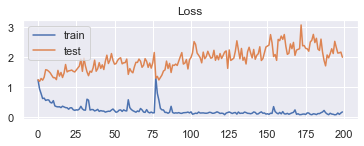

In [74]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

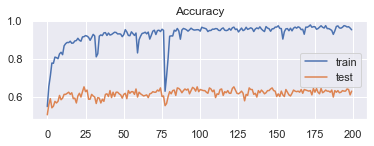

In [75]:
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

## Keras Model Implementation Using 'MSE' Method

In [77]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mse'])

In [78]:
# Model fit
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test),batch_size=30)

Train on 1412 samples, validate on 353 samples
Epoch 1/200
1412/1412 [==============================] - 65s 46ms/step - loss: 0.1335 - mse: 0.1204 - val_loss: 0.1909 - val_mse: 0.1840
Epoch 2/200
1412/1412 [==============================] - 61s 43ms/step - loss: 0.1626 - mse: 0.1566 - val_loss: 0.1836 - val_mse: 0.1748
Epoch 3/200
1412/1412 [==============================] - 49s 34ms/step - loss: 0.1493 - mse: 0.1435 - val_loss: 0.1773 - val_mse: 0.1720
Epoch 4/200
1412/1412 [==============================] - 47s 33ms/step - loss: 0.1399 - mse: 0.1308 - val_loss: 0.1889 - val_mse: 0.1815
Epoch 5/200
1412/1412 [==============================] - 53s 38ms/step - loss: 0.1127 - mse: 0.1062 - val_loss: 0.1706 - val_mse: 0.1630
Epoch 6/200
1412/1412 [==============================] - 46s 33ms/step - loss: 0.1339 - mse: 0.1242 - val_loss: 0.2039 - val_mse: 0.1978
Epoch 7/200
1412/1412 [==============================] - 46s 32ms/step - loss: 0.1137 - mse: 0.1077 - val_loss: 0.1741 - val_mse: 0

1412/1412 [==============================] - 37s 26ms/step - loss: 0.0397 - mse: 0.0376 - val_loss: 0.1558 - val_mse: 0.1523
Epoch 61/200
1412/1412 [==============================] - 37s 26ms/step - loss: 0.0391 - mse: 0.0364 - val_loss: 0.1708 - val_mse: 0.1675
Epoch 62/200
1412/1412 [==============================] - 38s 27ms/step - loss: 0.0493 - mse: 0.0465 - val_loss: 0.1554 - val_mse: 0.1513
Epoch 63/200
1412/1412 [==============================] - 37s 26ms/step - loss: 0.0451 - mse: 0.0423 - val_loss: 0.1601 - val_mse: 0.1553
Epoch 64/200
1412/1412 [==============================] - 40s 28ms/step - loss: 0.0324 - mse: 0.0300 - val_loss: 0.1689 - val_mse: 0.1648
Epoch 65/200
1412/1412 [==============================] - 37s 26ms/step - loss: 0.0308 - mse: 0.0289 - val_loss: 0.1591 - val_mse: 0.1554
Epoch 66/200
1412/1412 [==============================] - 36s 25ms/step - loss: 0.0254 - mse: 0.0238 - val_loss: 0.1547 - val_mse: 0.1516
Epoch 67/200
1412/1412 [=======================

1412/1412 [==============================] - 72s 51ms/step - loss: 0.0269 - mse: 0.0251 - val_loss: 0.1665 - val_mse: 0.1631
Epoch 120/200
1412/1412 [==============================] - 74s 52ms/step - loss: 0.0252 - mse: 0.0238 - val_loss: 0.1589 - val_mse: 0.1537
Epoch 121/200
1412/1412 [==============================] - 82s 58ms/step - loss: 0.0271 - mse: 0.0254 - val_loss: 0.1650 - val_mse: 0.1613
Epoch 122/200
1412/1412 [==============================] - 76s 54ms/step - loss: 0.0267 - mse: 0.0249 - val_loss: 0.1711 - val_mse: 0.1674
Epoch 123/200
1412/1412 [==============================] - 83s 59ms/step - loss: 0.0326 - mse: 0.0310 - val_loss: 0.1607 - val_mse: 0.1573
Epoch 124/200
1412/1412 [==============================] - 76s 54ms/step - loss: 0.0244 - mse: 0.0226 - val_loss: 0.1687 - val_mse: 0.1647
Epoch 125/200
1412/1412 [==============================] - 105s 74ms/step - loss: 0.0617 - mse: 0.0599 - val_loss: 0.1835 - val_mse: 0.1782
Epoch 126/200
1412/1412 [===============

Epoch 178/200
1412/1412 [==============================] - 96s 68ms/step - loss: 0.0292 - mse: 0.0280 - val_loss: 0.1773 - val_mse: 0.1754
Epoch 179/200
1412/1412 [==============================] - 96s 68ms/step - loss: 0.0549 - mse: 0.0535 - val_loss: 0.1560 - val_mse: 0.1525
Epoch 180/200
1412/1412 [==============================] - 89s 63ms/step - loss: 0.0737 - mse: 0.0715 - val_loss: 0.1834 - val_mse: 0.1802
Epoch 181/200
1412/1412 [==============================] - 96s 68ms/step - loss: 0.0436 - mse: 0.0418 - val_loss: 0.1686 - val_mse: 0.1658
Epoch 182/200
1412/1412 [==============================] - 91s 65ms/step - loss: 0.0240 - mse: 0.0232 - val_loss: 0.1656 - val_mse: 0.1633
Epoch 183/200
1412/1412 [==============================] - 96s 68ms/step - loss: 0.0256 - mse: 0.0245 - val_loss: 0.1783 - val_mse: 0.1754
Epoch 184/200
1412/1412 [==============================] - 94s 67ms/step - loss: 0.0428 - mse: 0.0411 - val_loss: 0.1750 - val_mse: 0.1730
Epoch 185/200
1412/1412 [==

In [79]:
# evaluate the model
_, train_mse = model.evaluate(X_train, y_train)
_, test_mse = model.evaluate(X_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

353/353 [==============================] - 4s 12ms/step
Train: 0.023, Test: 0.157


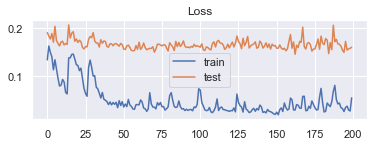

In [80]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

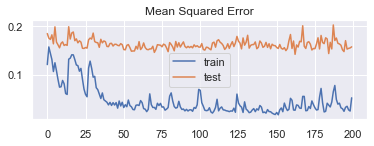

In [82]:
# plot mse during training
pyplot.subplot(212)
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['mse'], label='train')
pyplot.plot(history.history['val_mse'], label='test')
pyplot.legend()
pyplot.show()